In [5]:
from PySpice.Unit import *
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Xyce.Simulation import XyceServer, XyceCircuitSimulator
from PySpice.Spice.Simulation import CircuitSimulation
from PySpice.Spice.Xyce.RawFile import RawFile
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from warnings import warn

# TODO: Wrap these up in a class

# RawFile to Pandas DataFrame functions
def raw_nodes_to_df(
    raw : RawFile,
    all_nodes : bool = True,
    keep_nodes : list = []
) -> pd.DataFrame:
    ''' Get node voltages from raw file
    Args:
        raw: a PySpice RawFile object
        all_nodes : are all node voltages kept
        keep_nodes : if all_nodes is False, which node volatges do we keep
    
    Returns:
        A Pandas DataFrame with node voltage data
    '''
    data = {}
    for node in raw.nodes():
        # If you want to see everything available
        if(all_nodes or (node.name in keep_nodes)):
            data[node.name] = node.as_ndarray()
    return pd.DataFrame.from_dict(data)

def raw_iv_to_df(
    raw : RawFile,
    keep_i : bool = True,
    keep_v : bool = True,
    keep_all : bool = True,
    keep_vars : list = []
) -> pd.DataFrame:
    ''' Get node voltages and/or branch currents from raw file
    Args:
        raw: a PySpice RawFile object
        keep_i : are branch currents kept
        keep_v : are node voltages kept
        keep_all : are all branch currents and/or node volatges kept
        keep_vars : if keep_all is False, which branch currents and/or node volatges to keep
    
    Returns:
        A Pandas DataFrame with branch current and/or node voltage data
    '''
    data = {}
    var_dict = raw.variables
    for key in var_dict.keys():
        variable = var_dict[key]
        wf = variable.to_waveform()
        name = variable.name
        is_node = variable.is_voltage_node() 
        is_curr = variable.is_branch_current()
        if((is_node and keep_v) or (is_curr and keep_i)):
            if(keep_all or (name in keep_vars)):
                wf_d = wf.as_ndarray()
                data[name] = wf_d
    return pd.DataFrame.from_dict(data)

# Post-processing functions
def get_edges(
    wf_df_interval : pd.DataFrame,
    signal : str,
    polarity : str,
    pct_vdd : float,
    vdd : float
) -> dict:
    '''Get signal edges
    
    Args:
        wf_df_interval: a dataframe with simulation data for some time interval
        signal : the name of the singla under analysis (corresponds to a column in the dataframe)
        polarity : "posedge", "negedge", or "both"
        pct_vdd : the transition threshold expressed as a percentage of vdd
        vdd : the circuit vdd
    
    Returns:
        A dictionary formatted as follows
        {
            "edge_indices" : [the df index of each edge]
            "edge_polarities" : [the polarity of each edge]
        }
        
    Notes:
        The wf_df_interval DataFrame is expected to contain timeseries data. 
        Therefore, rows should be sorted w.r.t. the time column before calling this function!
    '''
    # Center the signal at the specified threshold
    signal_ts = wf_df_interval[signal]
    threshold = vdd*pct_vdd
    ts_amp_shift = signal_ts - threshold
    # Now an edge can be identified by locating where the signal 
    # transitions from positive to negative or vice a versa
    pols = []
    edge_indices = np.where(
        (np.diff(np.signbit(ts_amp_shift)) == True)
    )[0]
    if polarity == "both":
        # Determine the polarity of the transition
        for edge_idx in edge_indices:
            pols.append(
                "negedege" 
                if np.signbit(ts_amp_shift[edge_idx+2]) == 1 
                else "posedge"
            )
    else:
        edge_indices_tmp = []
        pol_bit = 1 if polarity=="negedge" else 0
        for edge_idx in edge_indices:
            if np.signbit(ts_amp_shift[edge_idx+2]) == pol_bit:
                edge_indices_tmp.append(int(edge_idx))
        edge_indices = edge_indices_tmp
        pols = [polarity]*len(edge_indices)
            
    return {
        "edge_idx" : edge_indices,
        "edge_pol" : pols
    }

# For "old-school" characterization methodology
# - We bump D transitions closer to the clock
# - Setup time is characterized for some threshold 
#   where bumping D increases the clk-q from nominal 
#   (i.e. 5%-10%).
def get_clk2qs(
    wf_df : pd.DataFrame,
    clock_col : str,
    clock_pol : str,
    q_col : str,
    time_col : str,
    interval : tuple,
    vdd : float,
    clk_edge_pct_vdd : float = 0.5,
    q_edge_pct_vdd : float = 0.5
) -> dict:
    wf_df_interval = wf_df.sort_values([time_col])
    wf_df_interval = wf_df_interval[
        (wf_df[time_col] >= interval[0]) &
        (wf_df[time_col] < interval[1])
    ]
    wf_df_interval.reset_index(drop=True)
    # Get clock active edges
    clk_edge_idxs = get_edges(
        wf_df_interval,
        signal=clock_col,
        polarity=clock_pol,
        pct_vdd = clk_edge_pct_vdd,
        vdd=vdd
    )
    clk2q_times = []
    clk2q_pols = []
    # For each edge find the Q-transition between active edges if one exists
    for edge_lst_idx, clk_edge_idx in enumerate(clk_edge_idxs["edge_idx"][-1]):
        wf_df_clk_interval = wf_df_interval[
            (wf_df_interval.index >= clk_edge_idx) &
            (wf_df_interval.index < clk_edge_idxs[edge_lst_idx+1])
        ]
        # Check for a Q-edge
        q_edge_idxs = get_edges(
            wf_df_clk_interval,
            signal=q_col,
            polarity="both",
            pct_vdd = q_edge_pct_vdd,
            vdd=vdd
        )
        n_q_trnsns = len(q_edge_idxs["edge_idx"])
        # Only take the first edge - there shouldn't be more than one edge
        if(n_q_trnsns > 0):
            if(n_q_trnsns > 1):
                warn(
                    "More thank one q-transition detected. Clock-to-q data might have errors."
                )
            t_clk = wf_df_clk_interval[time_col][clk_edge_idx]
            t_q = wf_df_clk_interval[time_col][q_edge_idxs["edge_idx"][0]]
            clk2q_times.append(t_q-t_clk)
            clk2q_pols.append(q_edge_idxs["edge_pol"][0])
            
    return {
        "clk2q_time" : clk2q_times,
        "clk2q_pol" : clk2q_pols
    }
        

# New-school methdology will simply require a functional check
# Ex. DFF can be checked by moving D transitions to the CLK active edge
# - Simply requires checking that the circuit functions
# - Development is shifted to generating a wide range of circuit permutations
#   - These permutations model process variation/mismatch @ different corners
#   - See the last cell for some preliminary work
# - Here is an example check for DFF functionality (called after bumping "D")

In [6]:
# Setup
XYCE_INSTALL        = "/opt/Xyce/XyceInstall/Parallel"
os.environ["PATH"] += os.pathsep + f"{XYCE_INSTALL}/bin"
SKY130_SPICE_LIB    = "/opt/pdks/open_pdks/sky130/sky130A/libs.tech/combined/sky130.lib.spice"
SKY130_STD_CELL_LIB = glob.glob("/opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/*.spice")

# TODO: How can we control Xyce parallel invocation with something like the following:
NUM_PROCESSORS      = 2
XYCE_COMMAND        = f"mpirun -np {NUM_PROCESSORS} Xyce -o results"

In [7]:
############ CUT DEFINITION
T_CLK_NS        = 40
INIT_D_PHASE_NS = 20  
V_DD            = 1.8

# Construct a circuit
circuit         = Circuit('DFF test circuit')

# Setup the library/includes
circuit.lib(SKY130_SPICE_LIB,"tt")
for inc in SKY130_STD_CELL_LIB:
    circuit.include(inc)

# VDD
circuit.V('DD', "VPWR", circuit.gnd, V_DD@u_V)

# Instantiate the DFF library subcircuit ('X')
circuit.X(
    'DFF',                          # Instance name
    'sky130_fd_sc_hd__dfxtp_4',     # Cell type
    ####### The following nodes are in the order of the subcircuit definition
    'CLK',                          # CLK
    'D',                            # D
    circuit.gnd,                    # VGND 
    circuit.gnd,                    # VNB
    'VPWR',                         # VPB
    'VPWR',                         # VPWR
    'Q' # Q
)

# Add some I/O cap
circuit.C(
    "OUT", 
    'Q', 
    circuit.gnd, 
    0.01@u_pF
)

circuit.C(
    "IN", 
    'D', 
    circuit.gnd, 
    0.01@u_pF
)

# Add pulse source for clock - clock parameters will be constant
# See https://pyspice.fabrice-salvaire.fr/releases/v1.3/api/PySpice/Spice/HighLevelElement.html
# Also look at the Xyce manual https://xyce.sandia.gov/files/xyce/Xyce_Users_Guide_7.8.pdf (search PULSE/VPULSE)
circuit.PulseVoltageSource(
    'CLK',                         # Instance name
    'CLK',                         # V+
    circuit.gnd,                   # V-
    0@u_V,                         # Vinit
    V_DD@u_V,                      # Vpulsed
    int(T_CLK_NS/2)@u_ns,          # Pulse width
    T_CLK_NS@u_ns,                 # Pulse period
    rise_time=100@u_ps,
    fall_time=100@u_ps
)

# Add pulse source for D input - D phase shift will be altered during subsequent runs
circuit.PulseVoltageSource(
    'D',                           # Instance name
    'D',                           # V+ node name
    circuit.gnd,                   # V- node name
    0@u_V,                         # Vinit
    V_DD@u_V,                      # Vpulsed
    int(T_CLK_NS)@u_ns,             # Pulse width
    2*T_CLK_NS@u_ns,                 # Pulse period
    delay_time = INIT_D_PHASE_NS@u_ns,
    rise_time=100@u_ps,
    fall_time=100@u_ps
)

# Show the SPICE we've generated so far
print(circuit)

.title DFF test circuit
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
.lib /opt/pdks/open_pdks/sky130/sky130A/libs.tech/combined/sky130.lib.spice tt
VDD VPWR 0 1.8V
XDFF CLK D 0 0 VPWR VPWR Q sky130_fd_sc_hd__dfxtp_4
COUT Q 0 0.01pF
CIN D 0 0.01pF
VCLK CLK 0 DC 0V PULSE(0V 1.8V 0s 100ps 100ps 20ns 40ns)
VD D 0 DC 0V PULSE(0V 1.8V 20ns 100ps 100ps 40ns 80ns)



In [4]:
# ############ DEFINE ANALYSIS
# temp = 100@u_Degree

# simulator = XyceCircuitSimulator(
#     circuit, 
#     temperature=temp, 
#     nominal_temperature=temp
# )

# # Construct measurement for CLK-Q delay
# # - We could also perform these measurements in Python
# # - TODO: Recreate in Python - minimizing SPICE usage is preferred
# simulator.measure(
#     'TRAN',                                   # Measurement type
#     'tcq',                                    # Measurement name
#     f'TRIG v(CLK)={V_DD/2} CROSS=1 ',         # Trigger condition
#     f'TARG v(Q)={V_DD/2} CROSS=1 ',           # Target condition
#     f"FROM={T_CLK_NS}ns TO={T_CLK_NS*2}ns"    # Measurement period
# )

# # This is not a node voltage or current, so we need to explicitly save

# # Set the initial Q output to help convergence
# # - Requires the use_initial_condition option below
# # simulator.initial_condition(Q=V_DD@u_V)

# # Perform transient analysis on the circuit
# # - We could do this but we lose some flexibility
# # - I noticed that the measurements not easy to extract (maynot be possible)
# analysis = simulator.transient(
#     step_time=0.1@u_ps, 
#     end_time=100.0@u_ns,
#     use_initial_condition=True
# )
# print(simulator)
# print(analysis)

# # Plot the data
# figure, ax = plt.subplots(figsize=(20, 10))
# ax.plot(
#     analysis['D'], 
#     label="D"
# )
# ax.plot(
#     analysis['CLK'], 
#     label="CLK"
# )
# ax.plot(
#     analysis['Q'],
#     label="Q"
# )
# ax.legend()
# ax.grid(
#     visible=True,
#     which='both'
# )

# ax.set_xlabel("Time (ns)")
# ax.set_ylabel("Voltage")
# ax.set_title("Transient Simulation DFF Setup/Hold Characterization")
# plt.tight_layout()
# plt.show()

In [8]:
############ DEFINE ANALYSIS
temp = 100@u_Degree

# Same
simulator = CircuitSimulation(
    circuit, 
    temperature=temp, 
    nominal_temperature=temp,
)

# Same
# simulator.measure(
#     'TRAN',                                   # Measurement type
#     'tcq',                                    # Measurement name
#     f'TRIG v(CLK)={V_DD/2} CROSS=1 ',         # Trigger condition
#     f'TARG v(Q)={V_DD/2} CROSS=1 ',           # Target condition
#     f"FROM={T_CLK_NS}ns TO={T_CLK_NS*2}ns"    # Measurement period
# )

# Same
#simulator.initial_condition(Q=V_DD@u_V)
simulator.SIMULATOR='xyce-parallel'

# Same
simulator.transient(
    step_time=1@u_ns, 
    end_time=100@u_ns,
    use_initial_condition=True,
    max_time=0.5@u_ps
)

simulator.save_currents = True

print(simulator)

xyce_server = XyceServer()
raw = xyce_server(f"{simulator}")

# Keep everything (need to be more selective for larger simulations)
wf_df = raw_iv_to_df(
    raw=raw,
    keep_i= True,
    keep_v=True,
    keep_all=True
)

print(f"N-Points: {wf_df.index}")

for col in wf_df.columns:
    print(col)

.title DFF test circuit
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
.include /opt/pdks/open_pdks/sky130/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
.lib /opt/pdks/open_pdks/sky130/sky130A/libs.tech/combined/sky130.lib.spice tt
VDD VPWR 0 1.8V
XDFF CLK D 0 0 VPWR VPWR Q sky130_fd_sc_hd__dfxtp_4
COUT Q 0 0.01pF
CIN D 0 0.01pF
VCLK CLK 0 DC 0V PULSE(0V 1.8V 0s 100ps 100ps 20ns 40ns)
VD D 0 DC 0V PULSE(0V 1.8V 20ns 100ps 100ps 40ns 80ns)
.options TEMP = 100C
.options TNOM = 100C
.options SAVECURRENTS = True
.tran 1ns 100ns 0s 0.5ps uic
.end




Netlist warning in file /tmp/tmpnn26flwk/input.cir at or near line 16

Netlist warning in file /tmp/tmpnn26flwk/input.cir at or near line 16

Netlist warning: No print specified

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in file

Netlist warning in f

N-Points: RangeIndex(start=0, stop=200046, step=1)
time
CLK
D
M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_BodyPrime
M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_DrainBody
M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_drainprime
M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_SourceBody
M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_sourceprime
M:XDFF:X10:SKY130_FD_PR__PFET_01V8_HVT_BodyPrime
M:XDFF:X10:SKY130_FD_PR__PFET_01V8_HVT_DrainBody
M:XDFF:X10:SKY130_FD_PR__PFET_01V8_HVT_drainprime
M:XDFF:X10:SKY130_FD_PR__PFET_01V8_HVT_SourceBody
M:XDFF:X10:SKY130_FD_PR__PFET_01V8_HVT_sourceprime
M:XDFF:X11:SKY130_FD_PR__PFET_01V8_HVT_BodyPrime
M:XDFF:X11:SKY130_FD_PR__PFET_01V8_HVT_DrainBody
M:XDFF:X11:SKY130_FD_PR__PFET_01V8_HVT_drainprime
M:XDFF:X11:SKY130_FD_PR__PFET_01V8_HVT_SourceBody
M:XDFF:X11:SKY130_FD_PR__PFET_01V8_HVT_sourceprime
M:XDFF:X12:SKY130_FD_PR__PFET_01V8_HVT_BodyPrime
M:XDFF:X12:SKY130_FD_PR__PFET_01V8_HVT_DrainBody
M:XDFF:X12:SKY130_FD_PR__PFET_01V8_HVT_drainprime
M:XDFF:X12:SKY130_FD_PR__PFET_01V8_HVT_SourceBod

Example result from calling get_edges
{'edge_idx': [101, 80113], 'edge_pol': ['posedge', 'posedge']}
               time     CLK    D  \
101    4.004975e-08  0.8955  1.8   
80113  8.004975e-08  0.8955  0.0   

       M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_BodyPrime  \
101                                           1.799998   
80113                                         1.799999   

       M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_DrainBody  \
101                                           1.799998   
80113                                         1.799999   

       M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_drainprime  \
101                                           -0.000763   
80113                                          1.800342   

       M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_SourceBody  \
101                                            1.799999   
80113                                          1.799999   

       M:XDFF:X0:SKY130_FD_PR__PFET_01V8_HVT_sourceprime  \
101                     

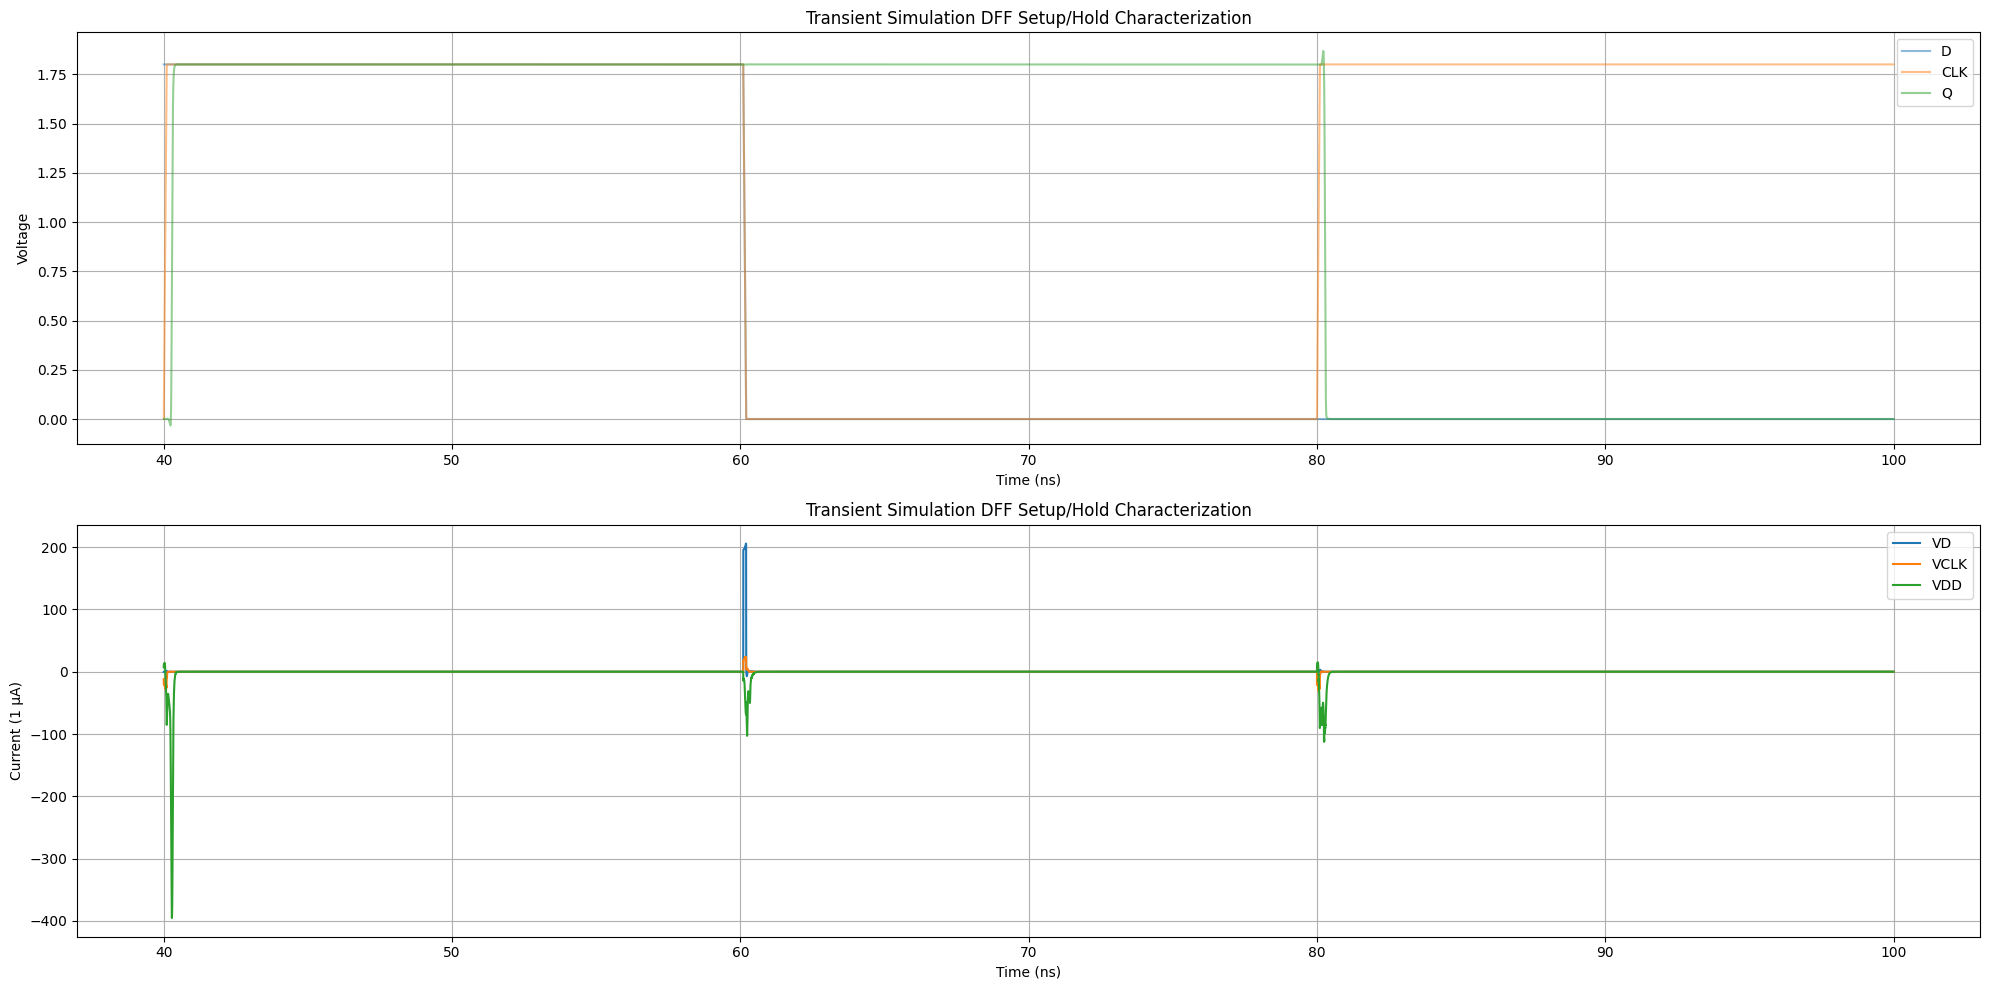

In [12]:
# Add some formatted columns, and trim the first edge
wf_df["time_ns"] = wf_df["time"]/10**-9
current_branches = [
    "VD#branch",
    "VCLK#branch",
    "VDD#branch"
]
for branch in current_branches:
    wf_df[branch+"_uA"] = wf_df[branch]/10**-6

wf_df = wf_df[wf_df['time']>T_CLK_NS@u_ns]
wf_df = wf_df.sort_values(['time']).reset_index(drop=True)

# Putting this call here as an example
# Get clock edges
clk_edges = get_edges(
    wf_df,
    'CLK',
    "posedge",
    0.5,
    1.8
)
print("Example result from calling get_edges")
print(clk_edges)
print(wf_df.iloc[clk_edges["edge_idx"]])

# Putting this call here as an example
# Get clk2q times
# clk2q_dict = get_clk2qs(
#     wf_df,
#     'CLK',
#     "posedge",
#     'Q',
#     "time_ns",
#     (20, 100),
#     1.8
# )
# print("Example result from calling get_clk2qs")
# print(clk2q_dict)

# Plot Voltages
opacity = 0.5
figure, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(
    wf_df["time_ns"],
    wf_df["D"], 
    label="D", 
    alpha=1
)
ax[0].plot(
    wf_df["time_ns"],
    wf_df["CLK"], 
    label="CLK", 
    alpha=opacity
)
ax[0].plot(
    wf_df["time_ns"],
    wf_df["Q"],
    label="Q", 
    alpha=opacity
)
ax[0].legend()
ax[0].grid(
    visible=True,
    which='both'
)
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Voltage")
ax[0].set_title("Transient Simulation DFF Setup/Hold Characterization")

# Plot Source branch currents

ax[1].plot(
    wf_df["time_ns"],
    wf_df["VD#branch_uA"], 
    label="VD"
)
ax[1].plot(
    wf_df["time_ns"],
    wf_df["VCLK#branch_uA"], 
    label="VCLK"
)

ax[1].plot(
    wf_df["time_ns"],
    wf_df["VDD#branch_uA"], 
    label="VDD"
)

ax[1].legend()
ax[1].grid(
    visible=True,
    which='both'
)
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel(f"Current ({1@u_uA})")
ax[1].set_title("Transient Simulation DFF Setup/Hold Characterization")

plt.tight_layout()
plt.show()

In [ ]:
# TODO: Model process variation, mismatch, thermal, and parasitics w/ Skywater 130
# Here are some starting bits that should make development pretty straightforward

# Discussions on mismatch and Monte Carlo
# https://electronics.stackexchange.com/questions/81709/how-to-find-setup-time-and-hold-time-for-d-flip-flop
# https://github.com/google/skywater-pdk/issues/309
# https://github.com/RTimothyEdwards/open_pdks/issues/201

# Random seed and multiple runs required for all below ciecuit variations
simulator.options("SEED=random")

# Mismatch: Rebuild circuit with mismatch library @ various corners
circuit.lib(SKY130_SPICE_LIB,"tt_mm")
circuit.lib(SKY130_SPICE_LIB,"ss_mm")
# ...

# Process variation: Rebuild circuit with the Monte Carlo simulation library
# TODO: Check for compatibility issues with Xyce
circuit.lib(SKY130_SPICE_LIB,"mc")

# Parasitics - Append to a larger circuit after physical design
# NOTE: When parasticis are appended there will be no need for I/O caps
# After larger circuit is construced pull out parasitics and DFF
# re-run mismatch analysis
# re-run process variation analysis

# Thermal should be considered for all the above
# - It is easy to alter
# - See simulator instantiation above

print(simulator)